## Fast Agent

In [1]:
import { SqlDatabase } from "langchain/sql_db";
import { DataSource } from "typeorm";

const datasource = new DataSource({
    type: "sqlite",
    database: "./Chinook.db", // Replace with the link to your database
});
const db = await SqlDatabase.fromDataSourceParams({
    appDataSource: datasource,
});

In [2]:
import { tool } from "langchain";
import { z } from "zod";

export const executeSQL = tool(({ query }) => {
    return db.run(query)
}, {
    name: "execute_sql",
    description: "Execute a SQLite command and return results.",
    schema: z.object({ query: z.string() })
})

In [3]:
export const systemPrompt = `You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool \`execute_sql\` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.`

In [4]:
import "dotenv/config"
import { createAgent } from "langchain";

const agent = createAgent({
    model: "openai:gpt-5",
    tools: [executeSQL],
    systemPrompt,
})

[Module: null prototype] { default: {}, "module.exports": {} }

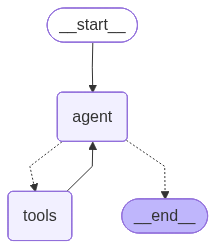

In [5]:
await agent.drawMermaidPng()

In [8]:
const question = "Which table has the largest number of entries?"
const stream = await agent.stream({
    messages: question
}, {
    stream_mode: "values",
})

for await (const step of stream) {
    const lastMessage = step?.messages?.at(-1)
    console.log(`${lastMessage.type} - ${lastMessage.content}`)
}

human - Which table has the largest number of entries?
ai - 
tool - [{"name":"Album"},{"name":"Artist"},{"name":"Customer"},{"name":"Employee"},{"name":"Genre"},{"name":"Invoice"},{"name":"InvoiceLine"},{"name":"MediaType"},{"name":"Playlist"},{"name":"PlaylistTrack"},{"name":"Track"}]
ai - 
tool - [{"table_name":"PlaylistTrack","row_count":8715}]
ai - PlaylistTrack, with 8,715 entries.


In [9]:
const question = "Which genre on average has the longest tracks?"
const stream = await agent.stream({
    messages: question
}, {
    stream_mode: "values",
})

for await (const step of stream) {
    const lastMessage = step?.messages?.at(-1)
    console.log(`${lastMessage.type} - ${lastMessage.content}`)
}

human - Which genre on average has the longest tracks?
ai - 
tool - [{"name":"Album"},{"name":"Artist"},{"name":"Customer"},{"name":"Employee"},{"name":"Genre"},{"name":"Invoice"},{"name":"InvoiceLine"},{"name":"MediaType"},{"name":"Playlist"},{"name":"PlaylistTrack"},{"name":"Track"}]
ai - 
tool - [{"Genre":"Sci Fi & Fantasy","AvgMs":2911783.0384615385}]
ai - Sci Fi & Fantasy, with the highest average track length (about 2,911,783 ms ≈ 48.5 minutes).


In [10]:
const question = "What are all the tables?";
const stream = await agent.stream({
    messages: question
}, {
    stream_mode: "values",
})

for await (const step of stream) {
    const lastMessage = step?.messages?.at(-1)
    console.log(`${lastMessage.type} - ${lastMessage.content}`)
}

human - What are all the tables?
ai - 
tool - [{"name":"Album"},{"name":"Artist"},{"name":"Customer"},{"name":"Employee"},{"name":"Genre"},{"name":"Invoice"},{"name":"InvoiceLine"},{"name":"MediaType"},{"name":"Playlist"},{"name":"PlaylistTrack"},{"name":"Track"}]
ai - The database tables are:
- Album
- Artist
- Customer
- Employee
- Genre
- Invoice
- InvoiceLine
- MediaType
- Playlist
- PlaylistTrack
- Track
